# Hyperparameter combinations

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

metric = 'auc_relaxed'

dataset = 'kws'
base_path = f'/home/ec2-user/evaluations/{dataset}'

if metric == 'auc':
    value = 'roc_auc'
    intersection = '0.05'
if metric == 'leo_metric':
    value = 'leo_metric'
    intersection = '0'
if metric == 'auc_relaxed':
    value = 'roc_auc'
    intersection = '0.09'

In [52]:
import itertools

files_auc = [
    f'{base_path}/{metric}_SHAP_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_LR_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_RF_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
]


ps = [0.2, 0.3, 0.4]
ws = [1, 3, 5]
fs = ['euclidean']
ms = ['zeros', 'noise']
methods = ['SHAP', 'LR', 'RF']
dfs = []
for method, file_template in zip(methods, files_auc):
    for p, w, f, m in itertools.product(ps, ws, fs, ms):
        file_path = file_template.format(p, w, f, m)
        try:
            df = pd.read_csv(file_path, sep='\t')
            df['method'] = method
            df['mask_percentage'] = p
            df['window_size'] = w
            df['distance_function'] = f
            df['masking_strategy'] = m
            dfs.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_path}")

final_df = pd.concat(dfs, ignore_index=True)
mean_auc_df = final_df.groupby(['method', 'mask_percentage', 'masking_strategy', 'window_size'])[value].mean().reset_index()

In [53]:
files_auc_complete = [
    f'{base_path}/{metric}_SHAP_{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_LR_{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_RF_{{}}_{intersection}.tsv',
]

names = ["zeros", 'noise']
methods = ['SHAP', 'LR', 'RF']

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for name in names:
        file_path = file_template.format(name)
        try:
            df_combination = pd.read_csv(file_path, sep='\t')
            df_combination['method'] = method
            df_combination['name'] = name
            df_combinations.append(df_combination)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            
final_df_combination = pd.concat(df_combinations, ignore_index=True)


In [54]:
mean_auc_df_combination =final_df_combination.groupby(['method', 'name'])[value].mean().reset_index()

/tmp/ipykernel_277207/443981797.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
/tmp/ipykernel_277207/443981797.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),


/tmp/ipykernel_277207/443981797.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),


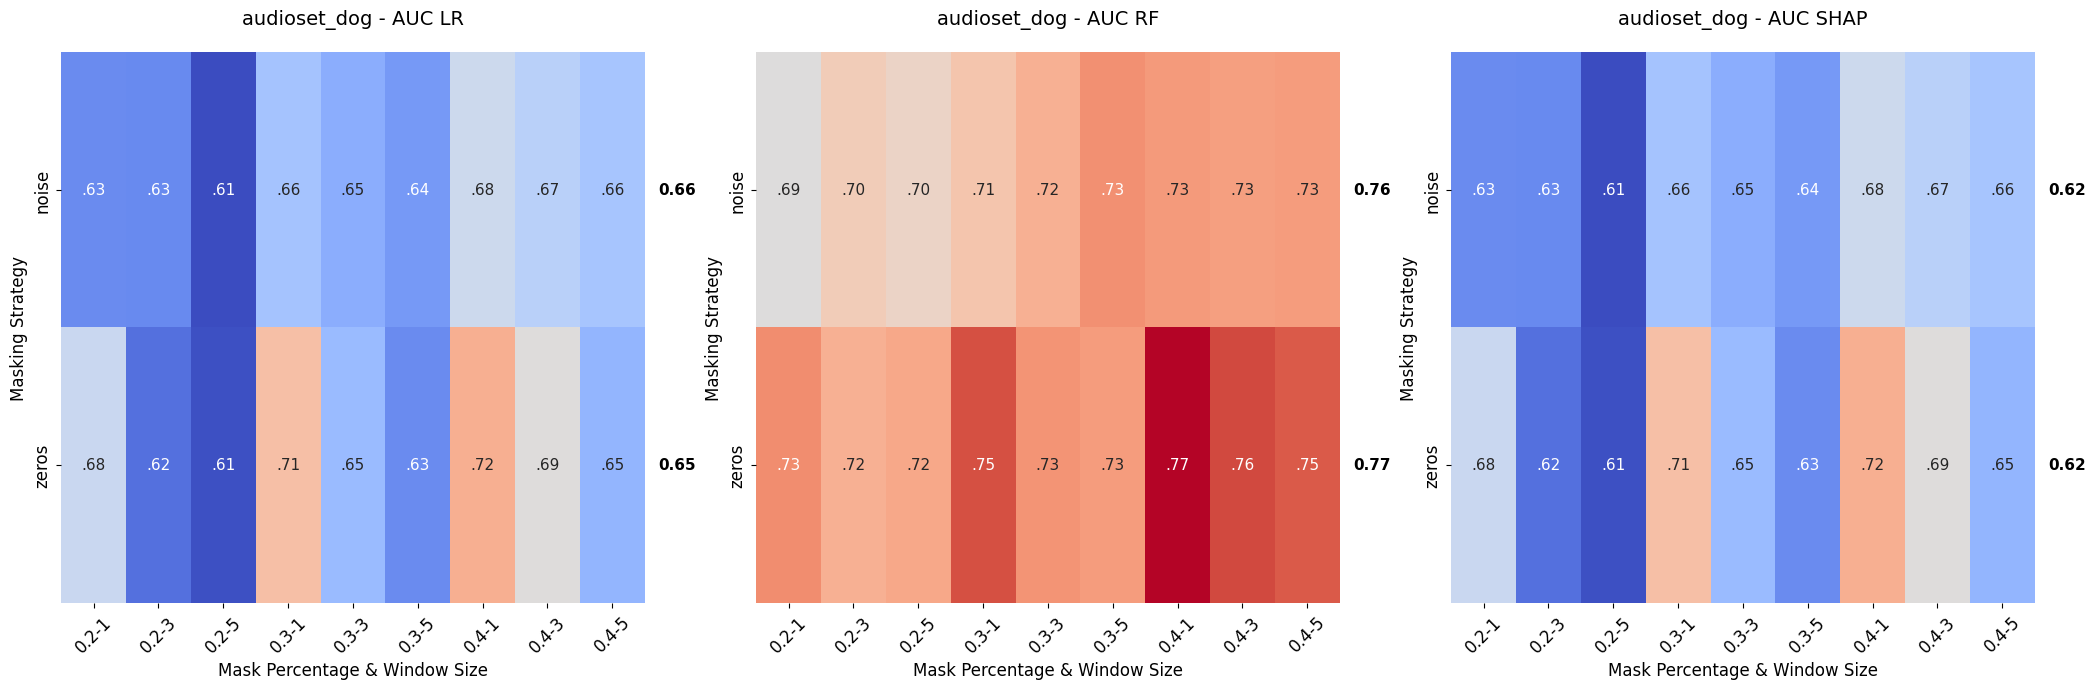

In [55]:
TITLE_SIZE = 14
LABEL_SIZE = 12
ANNOT_SIZE = 11
TICK_SIZE = 12

max_auc = mean_auc_df[value].max()
min_auc = mean_auc_df[value].min()

methods = mean_auc_df['method'].unique()
n_methods = len(methods)
n_cols = 3  
n_rows =1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 7*n_rows))
axes = axes.flatten()  # Flatten axes array for easier iteration
if n_methods < len(axes):
    for idx in range(n_methods, len(axes)):
        axes[idx].set_visible(False)

for idx, method in enumerate(methods):
    ax = axes[idx]

    # Create pivot table for current method
    pivot_table = mean_auc_df[mean_auc_df['method'] == method].pivot(
        index='masking_strategy', 
        columns=['mask_percentage', 'window_size'], 
        values=value
    )

    annotations = mean_auc_df_combination[mean_auc_df_combination['method'] == method].set_index('name')[value]
    row_labels = pivot_table.index
    row_annotations = [annotations.get(label, '') for label in row_labels]  # Get roc_auc or empty string

    sns.heatmap(
        pivot_table,
        annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
        cmap="coolwarm",
        fmt="",
        ax=ax,
        vmin=min_auc,
        vmax=max_auc,
        cbar=(idx == n_methods),
        annot_kws={'size': ANNOT_SIZE}
    )
    ax.set_title(f'{dataset} - AUC {method}', fontsize=TITLE_SIZE, pad=20)
    ax.set_xlabel('Mask Percentage & Window Size', fontsize=LABEL_SIZE)
    ax.set_ylabel('Masking Strategy', fontsize=LABEL_SIZE)

    # Set tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
    ax.tick_params(axis='x', rotation=45)
    # if idx == n_methods-1:
    #     cbar = plt.colorbar(ax.collections[0], ax=ax, fraction=0.02, pad=0.04)
    #     cbar.ax.tick_params(labelsize=4)
    for i, valu in enumerate(row_annotations):
        ax.text(pivot_table.shape[1] + 0.5, i + 0.5, f"{valu:.2f}" if valu else "", 
                ha='center', va='center', fontsize=ANNOT_SIZE, color='black', fontweight='bold')
plt.tight_layout()
plt.show()


In [56]:
import ast
from utils import clean_and_eval

metric = 'score_curve'
methods = ['SHAP', 'LR', 'RF']

base_path = f'/home/ec2-user/evaluations/{dataset}'

files_auc_complete = [
    f'{base_path}/{metric}_SHAP_{{}}.tsv',
    f'{base_path}/{metric}_LR_{{}}.tsv',
    f'{base_path}/{metric}_RF_{{}}.tsv',
]

names=['zeros', 'noise']
metric = 'score_curve'

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for name in names:
        file_path = file_template.format(name)
        try:
            df_combination = pd.read_csv(file_path, sep='\t')
            df_combination['method'] = method
            df_combination['name'] = name
            if dataset == "drums":
                df_combination['log_odds'] = df_combination['actual_score'].apply(clean_and_eval)
            else:
                df_combination['log_odds'] = df_combination['actual_score'].apply(ast.literal_eval)

            df_combination['log_odds_curve'] = df_combination['score_curve_sacando_topk'].apply(ast.literal_eval)
            df_combination['event_label'] = df_combination['event_label'].apply(int)
            percentages = [0.01, 0.05, 0.1, 0.2, 0.5]
            for i in percentages:
                df_combination[f'top_{i}'] = df_combination.apply(
                    lambda row: row['log_odds'][row['event_label']] - row['log_odds_curve'][int(len(row['log_odds_curve']) * i)][row['event_label']],
                    axis=1
                )

        except FileNotFoundError:
            print(f"File not found: {file_path}")

        df_combinations.append(df_combination)
            
final_df_combination_ff = pd.concat(df_combinations, ignore_index=True)

In [57]:
mean_auc_df_combination_ff = final_df_combination_ff.groupby(['method', 'name'])[['top_0.01', 'top_0.05', 'top_0.1', 'top_0.2', 'top_0.5']].mean().reset_index()
mean_auc_df_combination_ff

,method,name,top_0.01,top_0.05,top_0.1,top_0.2,top_0.5
0,LR,noise,0.400537,1.505232,2.608468,4.285595,6.312771
1,LR,zeros,0.328775,1.003971,2.249436,3.982201,6.634657
2,RF,noise,0.404105,1.388331,2.367244,3.552008,5.797241
3,RF,zeros,0.261422,0.779132,1.652723,3.068949,5.505657
4,SHAP,noise,0.452851,1.524772,2.472336,3.494492,5.183203
5,SHAP,zeros,0.406564,1.174399,1.963318,3.336148,5.705595


In [59]:
from scipy.stats import pearsonr

corr1, _ = pearsonr(mean_auc_df_combination['roc_auc'], mean_auc_df_combination_ff['top_0.01'])
corr5, _ = pearsonr(mean_auc_df_combination['roc_auc'], mean_auc_df_combination_ff['top_0.05'])
corr10, _ = pearsonr(mean_auc_df_combination['roc_auc'], mean_auc_df_combination_ff['top_0.1'])
corr20, _ = pearsonr(mean_auc_df_combination['roc_auc'], mean_auc_df_combination_ff['top_0.2'])
corr50, _ = pearsonr(mean_auc_df_combination['roc_auc'], mean_auc_df_combination_ff['top_0.5'])

print(f'Correlation for dataset {dataset}')
print(f'Correlation 1% {corr1}')
print(f'Correlation 5% {corr5}')
print(f'Correlation 10% {corr10}')
print(f'Correlation 20% {corr20}')
print(f'Correlation 50% {corr50}')

Correlation for dataset audioset_dog
Correlation 1% -0.5737196590908983
Correlation 5% -0.3961386763091408
Correlation 10% -0.39393865039277287
Correlation 20% -0.376480402036798
Correlation 50% -0.13100266907046318


## Prepare videos

In here we will create a video to look at the result, we need to select the instances to plot. In this case, we decided to filter by FF 20% as its the number that correlates more. And in that case 

In [60]:
final_df_combination_ff.groupby(["method", "name"], as_index=False).apply(lambda x: x.sort_values("top_0.2", ascending=True)).loc[2]


/tmp/ipykernel_277207/1817889981.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df_combination_ff.groupby(["method", "name"], as_index=False).apply(lambda x: x.sort_values("top_0.2", ascending=True)).loc[2]


,filename,event_label,actual_score,score_curve_sacando_topk,method,name,log_odds,log_odds_curve,top_0.01,top_0.05,top_0.1,top_0.2,top_0.5
374,Xecb_5XO81Q,74,"[1.8751014471054077, -7.396821022033691, -8.54...","[[1.9702082872390747, -7.381662845611572, -8.4...",RF,noise,"[1.8751014471054077, -7.396821022033691, -8.54...","[[1.9702082872390747, -7.381662845611572, -8.4...",0.003868,0.045223,0.159946,0.526624,4.774256
328,20qZLse0acs,74,"[-2.6014695167541504, -7.983034610748291, -8.8...","[[-2.223491907119751, -7.926583290100098, -8.6...",RF,noise,"[-2.6014695167541504, -7.983034610748291, -8.8...","[[-2.223491907119751, -7.926583290100098, -8.6...",-0.011645,-0.148102,-0.091739,0.632975,6.073623
378,v5IM8bUpeP8,74,"[2.54044246673584, -6.42817497253418, -7.31153...","[[2.6184725761413574, -6.403357028961182, -7.2...",RF,noise,"[2.54044246673584, -6.42817497253418, -7.31153...","[[2.6184725761413574, -6.403357028961182, -7.2...",0.260600,0.507877,0.674900,0.866970,2.684635
379,3qesirWAGt4,74,"[2.060041666030884, -6.971824645996094, -7.502...","[[2.190671920776367, -7.152204990386963, -7.35...",RF,noise,"[2.060041666030884, -6.971824645996094, -7.502...","[[2.190671920776367, -7.152204990386963, -7.35...",0.073868,0.394921,0.559381,0.885229,8.581872
383,3qesirWAGt4,74,"[2.060041666030884, -6.971824645996094, -7.502...","[[2.2010507583618164, -7.134280204772949, -7.3...",RF,noise,"[2.060041666030884, -6.971824645996094, -7.502...","[[2.2010507583618164, -7.134280204772949, -7.3...",0.073749,0.461029,0.714565,1.030047,8.522733
...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,Ey7CIPAeqsY,74,"[0.4784836173057556, -6.940800189971924, -8.19...","[[-0.055418677628040314, -6.602818489074707, -...",RF,noise,"[0.4784836173057556, -6.940800189971924, -8.19...","[[-0.055418677628040314, -6.602818489074707, -...",0.876860,1.607323,4.216042,7.625499,8.057104
355,JQwirnKysXI,74,"[3.476994514465332, -5.770900726318359, -7.090...","[[3.806462049484253, -3.9180009365081787, -5.5...",RF,noise,"[3.476994514465332, -5.770900726318359, -7.090...","[[3.806462049484253, -3.9180009365081787, -5.5...",5.100107,5.165893,7.539684,8.119509,8.069024
366,M4blyCNxeBQ,74,"[-0.1610027551651001, -6.727577209472656, -6.8...","[[-0.28679898381233215, -6.6677961349487305, -...",RF,noise,"[-0.1610027551651001, -6.727577209472656, -6.8...","[[-0.28679898381233215, -6.6677961349487305, -...",0.233982,1.830634,5.879105,8.221131,8.339009
380,DpLi9YH5idY,74,"[2.3720712661743164, -6.245989799499512, -7.46...","[[1.8910768032073975, -6.268824577331543, -6.7...",RF,noise,"[2.3720712661743164, -6.245989799499512, -7.46...","[[1.8910768032073975, -6.268824577331543, -6.7...",0.326050,5.344487,7.562170,8.243021,8.885029


In [78]:
final_df_combination[final_df_combination["filename"] == "v5IM8bUpeP8"]

,filename,event_label,actual_score,real_order,model_order,roc_auc,true_markers,method,name
50,v5IM8bUpeP8,74.0,1.085581,[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. ...,[ 0.07079193 0.03549889 0.08461371 0.045872...,0.543629,"[[0.0, 0.899], [6.349, 6.555], [6.953, 7.138],...",SHAP,zeros
106,v5IM8bUpeP8,74.0,1.085581,[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. ...,[ 0.28484538 0.0070775 0.02059276 0.036635...,0.633205,"[[0.0, 0.899], [6.349, 6.555], [6.953, 7.138],...",SHAP,noise
162,v5IM8bUpeP8,74.0,1.085581,[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. ...,[ 0.16661501 0.08101328 0.11624999 0.048663...,0.567568,"[[0.0, 0.899], [6.349, 6.555], [6.953, 7.138],...",LR,zeros
218,v5IM8bUpeP8,74.0,1.085581,[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. ...,[ 0.35175991 0.08499482 0.10374965 0.033840...,0.646332,"[[0.0, 0.899], [6.349, 6.555], [6.953, 7.138],...",LR,noise
274,v5IM8bUpeP8,74.0,1.085581,[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. ...,[0.01260237 0.01785029 0.01575189 0.00826409 0...,0.393822,"[[0.0, 0.899], [6.349, 6.555], [6.953, 7.138],...",RF,zeros
330,v5IM8bUpeP8,74.0,1.085581,[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. ...,[0.144504 0.01993604 0.01717053 0.00598643 0...,0.511969,"[[0.0, 0.899], [6.349, 6.555], [6.953, 7.138],...",RF,noise


In [79]:
from utils import create_visualization
import librosa

waveform, sr = librosa.load("/home/ec2-user/Datasets/audioset_eval_wav/v5IM8bUpeP8.wav", sr=16000)
json_file = f"/home/ec2-user/results/explanations_audioset/v5IM8bUpeP8/ast/ft_74_zeros.json"
output_file = "/home/ec2-user/explain_where/plots/audioset/v5IM8bUpeP8-dog.mp4"

create_visualization(waveform, json_file, output_file)


/home/ec2-user/explain_where/utils.py:233: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(time_points, values, 'k-', linewidth=1, color='black')


Saving temporary video...


# Drums test

In [40]:
base_path = f'/home/ec2-user/evaluations/drums'
metric = 'order'
names = ["zeros", "noise"]
methods = ['kernel_shap_sumcons', 'linear_regression_noreg_noweights', 'tree_importance']

files_auc_complete = [
    f'{base_path}/{metric}_kernel_shap_sumcons_{{}}_{{}}.tsv',
    f'{base_path}/{metric}_linear_regression_noreg_noweights_{{}}_{{}}.tsv',
    f'{base_path}/{metric}_tree_importance_{{}}_{{}}.tsv',
]
names = ["zeros", "noise"]

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for i in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]:
        for name in names:
            file_path = file_template.format(name, i)
            try:
                df_combination = pd.read_csv(file_path, sep='\t')
                if method == 'tree_importance':
                    df_combination['method'] = 'RF'
                if method == 'linear_regression_noreg_noweights':
                    df_combination['method'] = 'LR'
                if method == 'kernel_shap_sumcons':
                    df_combination['method'] = 'SHAP'
                df_combination['name'] = name
                df_combination['final'] = i
                df_combinations.append(df_combination)
            except FileNotFoundError:
                print(f"File not found: {file_path}")
                
final_df_combination = pd.concat(df_combinations, ignore_index=True)


In [56]:
final_df_combination['group'] = final_df_combination['method'] + '-' + \
                    final_df_combination['name'].astype(str)
final_df_combination = final_df_combination[final_df_combination['final'] != 0.1]

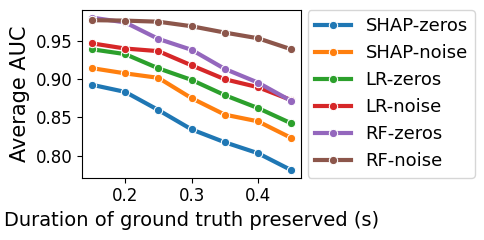

In [83]:
plt.figure(figsize=(5, 2.5))  # Hacemos el gráfico más compacto
sns.lineplot(data=final_df_combination, 
            x="final", 
            y="roc_auc", 
            hue="group", 
            marker="o",
            errorbar=None,
            linewidth=3)  # Líneas más gruesas

# Labels y título con fuentes grandes
plt.xlabel("Duration of ground truth preserved (s)", fontsize=14)
plt.ylabel("Average AUC", fontsize=15)

# Leyenda afuera y a lo largo
plt.legend(bbox_to_anchor=(1.03, 1), 
          loc='upper left', 
          borderaxespad=0.,
          fontsize=13)

plt.tick_params(axis='both', labelsize=12)  # Números de los ejes más grandes

# Ajustar los márgenes para que la leyenda no se corte
plt.tight_layout()

# Guardar en formato PDF sin márgenes adicionales
plt.savefig("drums_curves.pdf", format='pdf', bbox_inches='tight')

plt.show()

